In [2]:
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np
from geopandas.tools import sjoin
import time
from gethighs import HiGHS
import pyomo.environ as pyo
import folium
from tqdm import tqdm


# Ranh giới địa chính

In [3]:
# Đường dẫn đến tệp Shapefile (ví dụ như "gadm41_VNM_0.shp" hoặc tệp tương ứng bạn muốn phân tích)
file_path = "/Users/fuongfotfet/Desktop/vcb/gadm41_VNM_shp/gadm41_VNM_2.shp"  # thay "path_to_your_file" bằng đường dẫn thực tế của tệp

# Đọc dữ liệu từ Shapefile
gdf = gpd.read_file(file_path)

# Lọc khu vực hành chính muốn phân tích, ví dụ: "Hà Đông - Hà Nội"
selected_district = "Hà Đông"  # Tên khu vực bạn muốn phân tích
selected_gdf = gdf[gdf['NAME_2'] == selected_district]

# Kiểm tra dữ liệu đã lọc
print(selected_gdf)


           GID_2 GID_0  COUNTRY     GID_1  NAME_1 NL_NAME_1   NAME_2  \
238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA  Hà Đông   

    VARNAME_2 NL_NAME_2 TYPE_2       ENGTYPE_2 CC_2    HASC_2  \
238   Ha Dong        NA   Quận  Urban District   NA  VN.ND.HH   

                                              geometry  
238  POLYGON ((105.71912 20.9277, 105.71861 20.9272...  


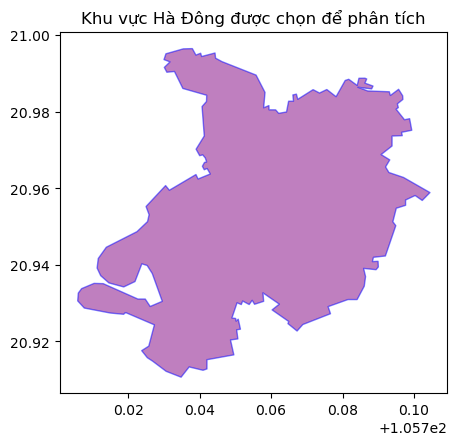

In [4]:
# Kiểm tra và hiển thị bản đồ khu vực Hà Đông
fig, ax = plt.subplots(figsize=(5, 5))
selected_gdf.plot(ax=ax, color="purple", edgecolor="blue", alpha=0.5)
plt.title(f"Khu vực {selected_district} được chọn để phân tích")
plt.show()

# Dân số Hà Đông

In [5]:
# Đọc dữ liệu dân số Hà Đông
population_data = pd.read_csv("/Users/fuongfotfet/Downloads/vnm_general_2020.csv")  

# Đổi tên các cột cho phù hợp (giả sử có các cột 'longitude', 'latitude', và 'population')
population_data.columns = ['longitude', 'latitude', 'population']

# Chuyển đổi thành GeoDataFrame
population_gdf = gpd.GeoDataFrame(
    population_data, 
    geometry=gpd.points_from_xy(population_data.longitude, population_data.latitude),
    crs="EPSG:4326"
)

# Tính toán dân số trong khu vực Hà Đông
population_in_hadong = sjoin(population_gdf, selected_gdf, how="inner", predicate="within")

# Kiểm tra dữ liệu sau khi xử lý
print(population_in_hadong.head())

          longitude   latitude  population                    geometry  \
4520065  105.737639  20.996250   14.904768  POINT (105.73764 20.99625)   
4521761  105.733194  20.995972    7.520281  POINT (105.73319 20.99597)   
4521762  105.735139  20.995972    7.520281  POINT (105.73514 20.99597)   
4521763  105.736528  20.995972    7.520281  POINT (105.73653 20.99597)   
4521764  105.737083  20.995972   14.904768  POINT (105.73708 20.99597)   

         index_right        GID_2 GID_0  COUNTRY     GID_1  NAME_1 NL_NAME_1  \
4520065          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   
4521761          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   
4521762          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   
4521763          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   
4521764          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   

          NAME_2 VARNAME_2 NL_NAME_2 TYPE_2       ENGTYPE_2 CC_2    HASC_2

In [6]:
population_in_hadong.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 23553 entries, 4520065 to 5020601
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   longitude    23553 non-null  float64 
 1   latitude     23553 non-null  float64 
 2   population   23553 non-null  float64 
 3   geometry     23553 non-null  geometry
 4   index_right  23553 non-null  int64   
 5   GID_2        23553 non-null  object  
 6   GID_0        23553 non-null  object  
 7   COUNTRY      23553 non-null  object  
 8   GID_1        23553 non-null  object  
 9   NAME_1       23553 non-null  object  
 10  NL_NAME_1    23553 non-null  object  
 11  NAME_2       23553 non-null  object  
 12  VARNAME_2    23553 non-null  object  
 13  NL_NAME_2    23553 non-null  object  
 14  TYPE_2       23553 non-null  object  
 15  ENGTYPE_2    23553 non-null  object  
 16  CC_2         23553 non-null  object  
 17  HASC_2       23553 non-null  object  
dtypes: float64(3), 

In [7]:
population_in_hadong['ID'] = population_in_hadong.index
print(population_in_hadong.head())  # Kiểm tra xem cột 'ID' đã được thêm vào chưa

          longitude   latitude  population                    geometry  \
4520065  105.737639  20.996250   14.904768  POINT (105.73764 20.99625)   
4521761  105.733194  20.995972    7.520281  POINT (105.73319 20.99597)   
4521762  105.735139  20.995972    7.520281  POINT (105.73514 20.99597)   
4521763  105.736528  20.995972    7.520281  POINT (105.73653 20.99597)   
4521764  105.737083  20.995972   14.904768  POINT (105.73708 20.99597)   

         index_right        GID_2 GID_0  COUNTRY     GID_1  NAME_1 NL_NAME_1  \
4520065          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   
4521761          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   
4521762          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   
4521763          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   
4521764          238  VNM.27.11_1   VNM  Vietnam  VNM.27_1  Hà Nội        NA   

          NAME_2 VARNAME_2 NL_NAME_2 TYPE_2       ENGTYPE_2 CC_2    HASC_2

In [8]:
print(population_in_hadong['ID'].is_unique)


True


In [9]:
print(population_in_hadong['population'].describe())

count    23553.000000
mean        14.656185
std          4.328512
min          5.593507
25%         11.525658
50%         17.200472
75%         17.200472
max         33.674764
Name: population, dtype: float64


# Dữ liệu ATM

In [10]:
# Đọc dữ liệu ATM

# Đọc dữ liệu từ tệp CSV
atm_data = pd.read_csv("/Users/fuongfotfet/Desktop/vcb/testfile/ATM_HaNoi_cleaned.csv")

# Kiểm tra các giá trị trong cột "LONGITUDE" và "LATITUDE" xem có giá trị không hợp lệ không
# Loại bỏ các hàng có khoảng trống hoặc giá trị không phải số
atm_data = atm_data[atm_data['LONGITUDE'].apply(lambda x: str(x).strip()).str.replace(' ', '') != '']
atm_data = atm_data[atm_data['LATITUDE'].apply(lambda x: str(x).strip()).str.replace(' ', '') != '']

# Chuyển đổi cột "LONGITUDE" và "LATITUDE" sang kiểu float
atm_data['LONGITUDE'] = atm_data['LONGITUDE'].astype(float)
atm_data['LATITUDE'] = atm_data['LATITUDE'].astype(float)

# Tạo cột geometry từ tọa độ
atm_data['geometry'] = atm_data.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)

# Chuyển đổi thành GeoDataFrame
atm_gdf = gpd.GeoDataFrame(atm_data, geometry='geometry', crs="EPSG:4326")


In [11]:
def filter_by_address(dataframe, keyword):
    """
    Lọc ra các dòng dữ liệu có chứa keyword trong cột address.

    Parameters:
    dataframe (pd.DataFrame): DataFrame chứa dữ liệu.
    keyword (str): Từ khóa để tìm kiếm trong cột address.

    Returns:
    pd.DataFrame: DataFrame chứa các dòng có từ khóa trong cột address.
    """
    # Lọc các dòng có chứa từ khóa trong cột 'address'
    filtered_df = dataframe[dataframe['ADR_02'].str.contains(keyword, case=False, na=False)]
    return filtered_df

# Ví dụ sử dụng hàm
# Giả sử bạn đã tải dữ liệu vào DataFrame tên là `du_lieu_sieuthi`
# du_lieu_sieuthi = pd.read_csv("path_to_your_data.csv")  # Đọc dữ liệu từ tệp

# Sử dụng hàm để lọc dữ liệu chứa "Hà Đông" trong cột 'address'
filtered_data = filter_by_address(atm_gdf, "HA DONG")
print(filtered_data)

       ATM_ID                            NAME                          ADR_01  \
62   10800336  PHENIKAA                        TRUONG  DAI HOC PHENIKAA, YEN    
82   10800397  TOA NHA TSQ MO LAO              CT1 KDT MO LAO                   
85   10800400  BHXH TP HA NOI                  15 CAU DO                        
111  10800514  10A QUANG TRUNG                 10 QUANG TRUNG, P QUANG TRUNG    
112  10800516  PGD QUANG TRUNG                 PGD QUANG TRUNG SO 80 QUANG TR   
114  10800519  DH CNGTVT                       DAI HOC CNGTVT, SO 54 PHO TRIE   
115  10800523  TRU SO CN TAY HA NOI            LO HH03 DUONG TO HUU, P.VAN PH   
120  10800544  SIEU THI COOP-MART              KM 10 DUONG NGUYEN TRAI          
121  10800545  PGD VAN QUAN                    BT8 LO 44 KHU DO THI VAN QUAN    
131  10800609  AEON HA DONG                    TANG 1 TTTM AEON HA DONG,TDP H   
180  10800531  PGD QUANG TRUNG VCB THN         80 QUANG TRUNG                   

                           

# Xây dựng lưới điểm tiềm năng

In [12]:
def generate_grid_in_polygon(spacing, geometry):
    """
    Tạo một lưới điểm đều trong một vùng đa giác.

    Parameters:
    - spacing (float): khoảng cách giữa các điểm trong lưới.
    - geometry (GeoDataFrame): ranh giới của khu vực (ví dụ: Hà Đông).

    Returns:
    - GeoDataFrame: Lưới điểm nằm trong ranh giới của khu vực.
    """
    # Xác định toạ độ biên của khu vực
    minx, miny, maxx, maxy = geometry.total_bounds

    # Tạo các toạ độ điểm đều nhau trong khu vực này
    x_coords = np.arange(minx, maxx, spacing)
    y_coords = np.arange(miny, maxy, spacing)
    mesh = np.meshgrid(x_coords, y_coords)
    points = np.vstack([mesh[0].ravel(), mesh[1].ravel()]).T

    # Chuyển đổi các điểm thành GeoDataFrame và lọc trong ranh giới
    points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(points[:, 0], points[:, 1]), crs="EPSG:4326")
    grid = points_gdf[points_gdf.within(geometry.unary_union)]
    return grid

# Gọi hàm với khoảng cách giữa các điểm là 0.005 độ (khoảng 500m)
grid_points = generate_grid_in_polygon(0.01, selected_gdf)  # selected_gdf là ranh giới của Hà Đông

# Kiểm tra kết quả
print(grid_points.info())
grid_points

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 42 entries, 13 to 84
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  42 non-null     geometry
dtypes: geometry(1)
memory usage: 672.0 bytes
None


/var/folders/sq/kyw5wnpn4jq0h5qkwphw144h0000gn/T/ipykernel_9767/4113932110.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid = points_gdf[points_gdf.within(geometry.unary_union)]


,geometry
13,POINT (105.73575 20.9208)
14,POINT (105.74575 20.9208)
21,POINT (105.71575 20.9308)
23,POINT (105.73575 20.9308)
24,POINT (105.74575 20.9308)
25,POINT (105.75575 20.9308)
26,POINT (105.76575 20.9308)
27,POINT (105.77575 20.9308)
31,POINT (105.71575 20.9408)
32,POINT (105.72575 20.9408)


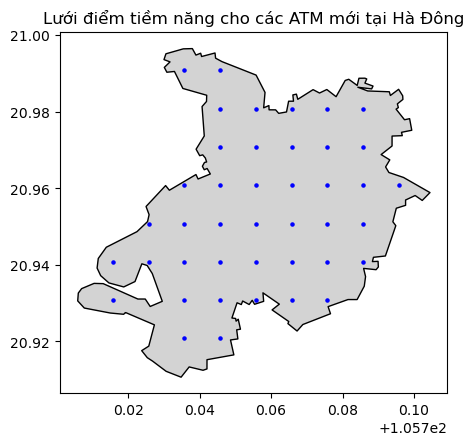

In [13]:
# Hiển thị bản đồ khu vực Hà Đông và lưới điểm tiềm năng
fig, ax = plt.subplots(figsize=(5, 5))
selected_gdf.plot(ax=ax, color="lightgrey", edgecolor="black")  # Hiển thị bản đồ Hà Đông
grid_points.plot(ax=ax, color="blue", markersize=5)  # Hiển thị lưới điểm tiềm năng
plt.title("Lưới điểm tiềm năng cho các ATM mới tại Hà Đông")
plt.show()

# Tính toán khả năng tiếp cận tối đa

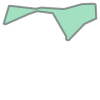

In [14]:
# Isochrone
def get_isochrone(lat, lon, duration, api_key):
    url = "https://api.openrouteservice.org/v2/isochrones/foot-walking"
    headers = {
        'Authorization': api_key
    }
    params = {
        'locations': [[lon, lat]],
        'range': [duration * 60],
        'interval': duration * 60,
        'attributes': ['total_pop']
    }
    
    response = requests.post(url, headers=headers, json=params)
    
    # Kiểm tra trạng thái phản hồi
    if response.status_code != 200:
        print("Lỗi API:", response.status_code, response.text)
        return None
    
    data = response.json()
    
    # Kiểm tra và chuyển đổi kết quả thành Polygon
    if 'features' in data and len(data['features']) > 0:
        coordinates = data['features'][0]['geometry']['coordinates'][0]
        polygon_geom = Polygon(coordinates)
        return polygon_geom
    else:
        print("Không thể tạo Isochrone.")
        return None
    
# Ví dụ sử dụng hàm cho một điểm bán hàng
lat, lon = 21.986552, 106.780302  # Tọa độ của điểm bán hàng
api_key = '5b3ce3597851110001cf62487450313b6e8642c8b42c0522c29c8c33'  # Thay thế bằng API key của bạn
isochrone = get_isochrone(lat, lon, duration=15, api_key=api_key)
isochrone

In [15]:
# Khởi tạo danh sách để lưu isochrones cho các điểm ATM hiện có
isochrones_existing_atm = []

# Vòng lặp qua các điểm ATM hiện có trong `filtered_data` và tính toán isochrone
for idx, row in filtered_data.iterrows():
    lat, lon = row.geometry.y, row.geometry.x
    
    # In ra thông báo tọa độ hiện tại đang xử lý
    print(f"Đang tạo isochrone cho tọa độ ATM hiện có: (lat: {lat}, lon: {lon})")
    
    # Gọi hàm tính isochrone
    isochrone_polygon = get_isochrone(lat, lon, duration=15, api_key=api_key)
    
    # Thêm thời gian chờ giữa các yêu cầu để tránh giới hạn API
    time.sleep(20)
    
    # Kiểm tra kết quả và thêm vào danh sách nếu thành công
    if isochrone_polygon:
        isochrones_existing_atm.append({
            'geometry': isochrone_polygon,
            'id': idx
        })
        print("Thành công")

# Chuyển danh sách isochrones thành GeoDataFrame
isochrone_existing_atm_gdf = gpd.GeoDataFrame(isochrones_existing_atm, crs="EPSG:4326")

# Kiểm tra dữ liệu isochrone của các ATM hiện có
print(isochrone_existing_atm_gdf)

Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.962821574027, lon: 105.74881514251)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.9865521, lon: 105.780302)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.96492, lon: 105.7710304)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.971941, lon: 105.776733)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.969898, lon: 105.774452)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.985271, lon: 105.798996)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.983171, lon: 105.772081)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.98298, lon: 105.79045)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.97812, lon: 105.79284)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.98797, lon: 105.75217)
Thành công
Đang tạo isochrone cho tọa độ ATM hiện có: (lat: 20.969898, lon: 105.774452)
Thành công
                          

In [16]:
# Kiểm tra dữ liệu isochrone của các ATM hiện có
isochrone_existing_atm_gdf = isochrone_existing_atm_gdf.set_index("id")
isochrone_existing_atm_gdf


,geometry
id,
62,"POLYGON ((105.73824 20.96224, 105.73878 20.957..."
82,"POLYGON ((105.77084 20.98508, 105.77036 20.983..."
85,"POLYGON ((105.75993 20.96128, 105.75992 20.961..."
111,"POLYGON ((105.76548 20.9685, 105.76616 20.9637..."
112,"POLYGON ((105.76278 20.96835, 105.76279 20.968..."
114,"POLYGON ((105.78866 20.9807, 105.78882 20.9805..."
115,"POLYGON ((105.76378 20.98595, 105.76379 20.985..."
120,"POLYGON ((105.77891 20.98506, 105.77931 20.982..."
121,"POLYGON ((105.78287 20.972, 105.78289 20.97194..."


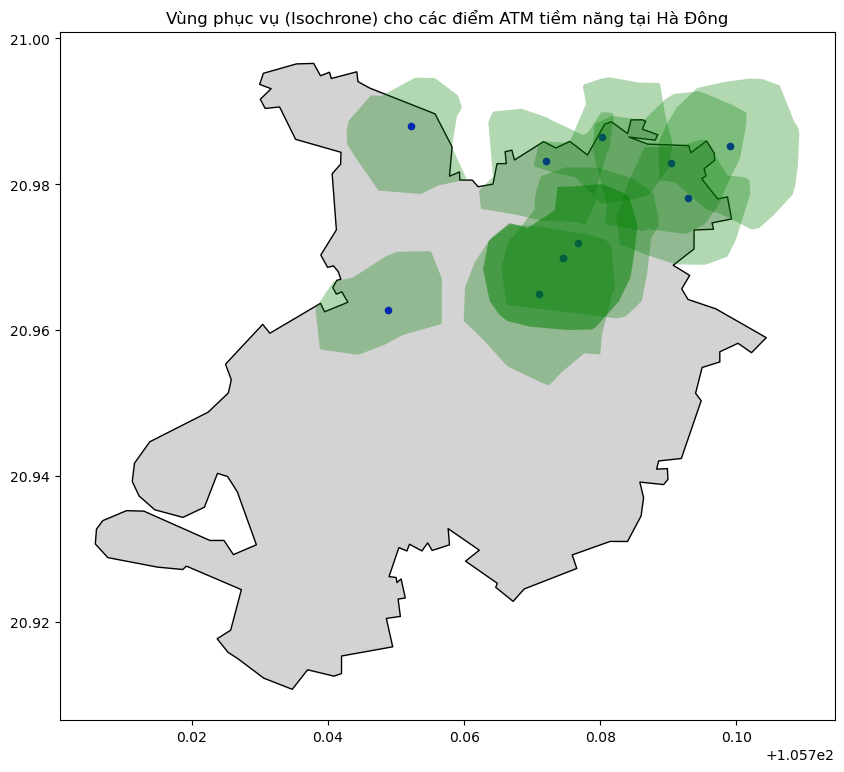

In [17]:
# Hiển thị bản đồ Hà Đông, lưới điểm tiềm năng và isochrone
fig, ax = plt.subplots(figsize=(10, 10))
selected_gdf.plot(ax=ax, color="lightgrey", edgecolor="black")  # Bản đồ Hà Đông
filtered_data.plot(ax=ax, color="blue", markersize=20)  # Lưới điểm tiềm năng
isochrone_existing_atm_gdf.plot(ax=ax, color="green", alpha=0.3)  # Isochrone (vùng phục vụ)
plt.title("Vùng phục vụ (Isochrone) cho các điểm ATM tiềm năng tại Hà Đông")
plt.show()

In [18]:
# API key cho OpenRouteService
api_key = "5b3ce3597851110001cf62487450313b6e8642c8b42c0522c29c8c33"  # Thay thế bằng API key thực tế của bạn

# Thời gian di chuyển tối đa (ví dụ, 15 phút = 900 giây)
travel_time = 15

# Khởi tạo danh sách để lưu isochrones
isochrones = []

# Vòng lặp qua các điểm trong lưới và tính toán isochrone cho các điểm tiềm năng
for idx, row in grid_points.iterrows():
    lat, lon = row.geometry.y, row.geometry.x
    
    # In ra thông báo tọa độ hiện tại đang xử lý
    print(f"Đang tạo isochrone cho tọa độ: (lat: {lat}, lon: {lon})")
    
    # Gọi hàm tính isochrone và thêm thời gian chờ giữa các yêu cầu
    isochrone_polygon = get_isochrone(lat, lon, duration=15, api_key=api_key)
    time.sleep(20)
    
    # Kiểm tra kết quả và thêm vào danh sách nếu thành công
    if isochrone_polygon:
        isochrones.append({
            'geometry': isochrone_polygon,
            'id': idx
        })
        print("Thành công")

# Chuyển danh sách isochrones thành GeoDataFrame
isochrone_gdf = gpd.GeoDataFrame(isochrones, crs="EPSG:4326")

Đang tạo isochrone cho tọa độ: (lat: 20.920800935000113, lon: 105.73574951100004)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.920800935000113, lon: 105.74574951100004)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.930800935000114, lon: 105.71574951100003)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.930800935000114, lon: 105.73574951100004)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.930800935000114, lon: 105.74574951100004)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.930800935000114, lon: 105.75574951100005)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.930800935000114, lon: 105.76574951100005)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.930800935000114, lon: 105.77574951100006)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.940800935000116, lon: 105.71574951100003)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.940800935000116, lon: 105.72574951100003)
Thành công
Đang tạo isochrone cho tọa độ: (lat: 20.940800935000116, lon: 105.7357

In [19]:
isochrone_gdf = isochrone_gdf.set_index('id')
isochrone_gdf

,geometry
id,
13,"POLYGON ((105.73175 20.92379, 105.73158 20.921..."
14,"POLYGON ((105.73546 20.92469, 105.73702 20.921..."
21,"POLYGON ((105.7054 20.92932, 105.70668 20.9244..."
23,"POLYGON ((105.7282 20.9376, 105.72809 20.93702..."
24,"POLYGON ((105.7358 20.93011, 105.73596 20.9294..."
25,"POLYGON ((105.74998 20.92995, 105.74986 20.929..."
26,"POLYGON ((105.75685 20.93214, 105.75686 20.931..."
27,"POLYGON ((105.77297 20.92323, 105.77331 20.922..."
31,"POLYGON ((105.71317 20.93827, 105.7139 20.9370..."


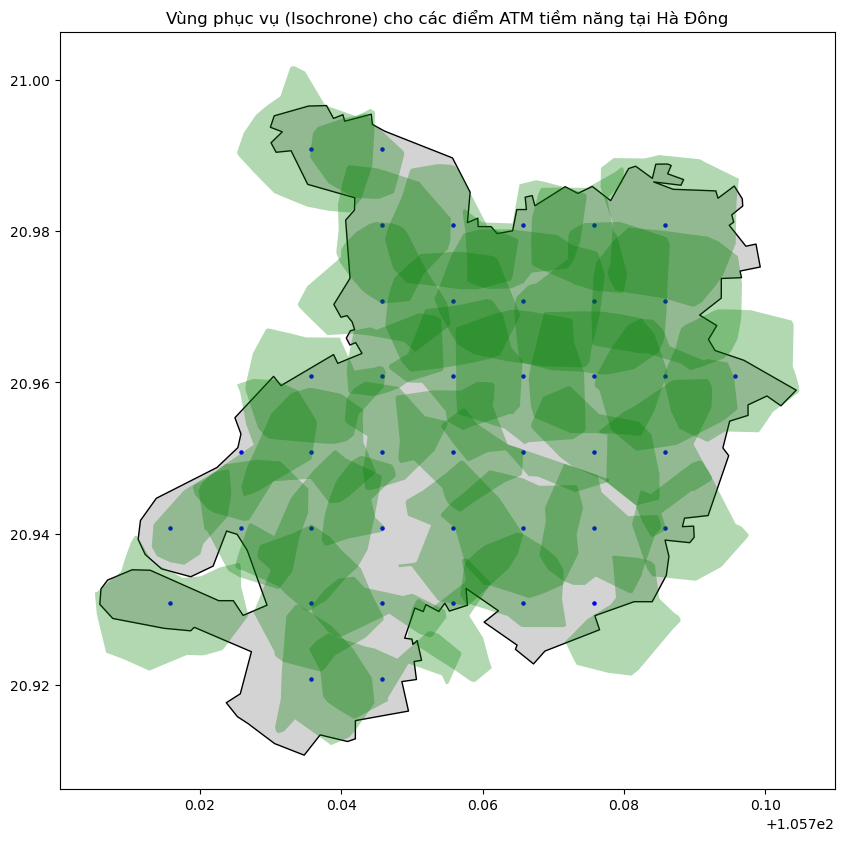

In [20]:
# Hiển thị bản đồ Hà Đông, lưới điểm tiềm năng và isochrone
fig, ax = plt.subplots(figsize=(10, 10))
selected_gdf.plot(ax=ax, color="lightgrey", edgecolor="black")  # Bản đồ Hà Đông
grid_points.plot(ax=ax, color="blue", markersize=5)  # Lưới điểm tiềm năng
isochrone_gdf.plot(ax=ax, color="green", alpha=0.3)  # Isochrone (vùng phục vụ)
plt.title("Vùng phục vụ (Isochrone) cho các điểm ATM tiềm năng tại Hà Đông")
plt.show()

In [21]:
def calculate_max_coverage(population_gdf, isochrone_gdf):
    """
    Tính toán khả năng tiếp cận tối đa của các điểm ATM tiềm năng.

    Parameters:
    - population_gdf (GeoDataFrame): Dữ liệu dân số với các điểm dân cư trong Hà Đông.
    - isochrone_gdf (GeoDataFrame): Dữ liệu isochrone của các điểm ATM tiềm năng.

    Returns:
    - float: Phần trăm dân số có thể tiếp cận tối đa.
    """
    # Bước 1: Kết hợp tất cả các isochrone lại thành một vùng phủ tối đa
    max_coverage_area = unary_union(isochrone_gdf.geometry)

    # Bước 2: Lọc các điểm dân cư nằm trong vùng phủ tối đa
    population_within_coverage = population_gdf[population_gdf.within(max_coverage_area)]

    # Bước 3: Tính tổng dân số trong vùng phủ tối đa
    covered_population = population_within_coverage['population'].sum()
    total_population = population_gdf['population'].sum()

    # Bước 4: Tính phần trăm dân số được phục vụ
    coverage_percentage = (covered_population / total_population) * 100
    return coverage_percentage

# Sử dụng hàm để tính khả năng tiếp cận tối đa
max_coverage_percentage = calculate_max_coverage(population_in_hadong, isochrone_gdf)
print(f"Khả năng tiếp cận tối đa của các điểm ATM tiềm năng: {max_coverage_percentage:.2f}%")

Khả năng tiếp cận tối đa của các điểm ATM tiềm năng: 96.69%


# Mô hình tối ưu hoá

In [22]:
w = population_in_hadong.set_index('ID')['population'].to_dict()

In [23]:
# Các điểm ATM hiện có trong khu vực Hà Đông
J_existing = set(filtered_data.index)
# Các điểm tiềm năng trong lưới điểm đã tạo
J_potential = set(grid_points.index)

In [24]:
J = sorted(J_existing | J_potential)  # Tất cả các điểm ATM
I = sorted(set(population_in_hadong['ID']))  # Tất cả các điểm dân cư

In [25]:
# Tạo ánh xạ từ ID cửa hàng tới các hộ gia đình có thể tiếp cận
IJ_existing = {
    atm_id: population_in_hadong[population_in_hadong['geometry'].within(isochrone_existing_atm_gdf.loc[atm_id, 'geometry'])].index.tolist()
    for atm_id in J_existing
}

IJ_potential = {
    atm_id: population_in_hadong[population_in_hadong['geometry'].within(isochrone_gdf.loc[atm_id, 'geometry'])].index.tolist()
    for atm_id in J_potential
}

In [26]:
IJ = {**IJ_existing, **IJ_potential}

In [27]:
for key, value in list(IJ.items()):
    print(key, value)

131 [4554261, 4554262, 4556023, 4556024, 4556025, 4556026, 4556027, 4556028, 4557728, 4557729, 4557730, 4557731, 4557732, 4557733, 4557734, 4557735, 4557736, 4557737, 4557738, 4559443, 4559444, 4559445, 4559446, 4559447, 4559448, 4559449, 4559450, 4559451, 4559452, 4559453, 4561242, 4561243, 4561244, 4561245, 4561246, 4561247, 4561248, 4561249, 4561250, 4561251, 4561252, 4561253, 4561254, 4561255, 4563093, 4563094, 4563095, 4563096, 4563097, 4563098, 4563099, 4563100, 4563101, 4563102, 4563103, 4563104, 4563105, 4563106, 4564947, 4564948, 4564949, 4564950, 4564951, 4564952, 4564953, 4564954, 4564955, 4564956, 4564957, 4566805, 4566806, 4566807, 4566808, 4566809, 4566810, 4566811, 4566812, 4566813, 4566814, 4566815, 4566816, 4566817, 4566818, 4568704, 4568705, 4568706, 4568707, 4568708, 4568709, 4568710, 4568711, 4568712, 4568713, 4568714, 4568715, 4568716, 4568717, 4568718, 4568719, 4570574, 4570575, 4570576, 4570577, 4570578, 4570579, 4570580, 4570581, 4570582, 4570583, 4570584, 45705

In [28]:
def reverse_mapping(mapping):
    from collections import defaultdict
    aux = defaultdict(set)
    for x, Y in mapping.items():
        for y in Y:
            aux[y].add(x)
    return {y: sorted(aux[y]) for y in sorted(aux.keys())}

JI = reverse_mapping(IJ)

In [29]:
for key, value in list(JI.items()):
    print(key, value)

4520065 [83]
4521761 [83]
4521762 [83]
4521763 [83]
4521764 [83]
4521765 [83]
4521766 [83]
4523474 [83]
4523475 [83]
4523476 [83]
4523477 [83]
4523478 [83]
4523479 [83]
4523480 [83]
4523481 [83]
4523482 [83]
4523483 [83]
4523484 [83]
4525292 [83]
4525293 [83]
4525294 [83]
4525295 [83]
4525296 [83]
4525297 [83]
4525298 [83]
4525299 [83]
4525300 [83]
4525301 [83]
4525312 [83]
4527071 [83]
4527072 [83]
4527073 [83]
4527074 [83]
4527075 [83]
4527076 [83]
4527077 [83]
4527078 [83]
4527079 [83]
4527082 [83]
4527083 [83]
4527084 [83]
4527094 [83, 84]
4527095 [83, 84]
4527096 [83, 84]
4527097 [83, 84]
4527098 [83]
4528862 [83]
4528863 [83]
4528864 [83]
4528865 [83]
4528866 [83]
4528867 [83]
4528868 [83]
4528869 [83]
4528870 [83]
4528871 [83]
4528872 [83]
4528873 [83]
4528874 [83]
4528880 [83, 84]
4528881 [83, 84]
4528882 [83, 84]
4528883 [83, 84]
4528884 [83, 84]
4528885 [83, 84]
4528886 [83, 84]
4530569 [83]
4530570 [83]
4530571 [83]
4530572 [83]
4530573 [83]
4530574 [83]
4530575 [83]
4530576

In [30]:
J_existing = sorted(J_existing)

In [31]:
def model_max_covering(w, I, J, JI, p, J_existing):
    # Đảm bảo rằng tất cả các điểm hiện có đều nằm trong tập hợp J
    assert set(J_existing).issubset(set(J))

    # Khởi tạo mô hình
    m = pyo.ConcreteModel("MaxCovering")

    # Khai báo tham số
    m.p = pyo.Param(mutable=True, within=pyo.Integers, default=p)
    m.I = pyo.Set(initialize=I)
    m.J = pyo.Set(initialize=J)
    m.Jfixed = pyo.Set(initialize=list(J_existing))
    m.nof_fixed = pyo.Param(mutable=False, within=pyo.Integers, default=len(J_existing))

    # Khai báo hàm trọng số dân số
    @m.Param(m.I, within=pyo.NonNegativeReals)
    def w(m, i):
        return w[i]

    # Khai báo hàm ánh xạ từ I đến J
    @m.Param(m.I, within=pyo.Any)
    def JI(m, i):
        return JI.get(i, [])

    # Khai báo biến quyết định
    m.x = pyo.Var(m.J, within=pyo.Binary)  # Quyết định có mở ATM ở vị trí j hay không
    m.z = pyo.Var(m.I, within=pyo.Binary)  # Quyết định khu vực dân cư i có được phục vụ hay không

    # Hàm mục tiêu: tối đa hóa dân số được phục vụ
    @m.Objective(sense=pyo.maximize)
    def covering(m):
        return pyo.quicksum(m.w[i] * m.z[i] for i in m.I)

    # Ràng buộc: Khu vực dân cư chỉ được phục vụ nếu có ít nhất một ATM trong phạm vi
    @m.Constraint(m.I)
    def serve_if_reachable_and_open(m, i):
        return m.z[i] <= pyo.quicksum(m.x[j] for j in m.JI[i])

    # Ràng buộc: Số lượng ATM mở không vượt quá `p` và `nof_fixed`
    @m.Constraint()
    def budget(m):
        return pyo.quicksum(m.x[j] for j in m.J) <= m.nof_fixed + m.p

    # Ràng buộc: Các ATM hiện có phải được mở
    @m.Constraint(m.Jfixed)
    def fix_open(m, j):
        return m.x[j] == 1

    return m

In [32]:
model = model_max_covering(w, I, J, JI, 3, J_existing)
model

In [33]:
solver = HiGHS(time_limit=10, mip_heuristic_effort=0.2, mip_detect_symmetry="on")
solver.solve(model)

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298011319092000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 T       0       0         0   0.00%   336206.608618  

'status: Optimal\nprimal_solutions: Feasible\nobjective: 213764.900846'

In [34]:
# Danh sách các điểm ATM được chọn
selected_ATMs = [j for j in J if model.x[j].value == 1]

# Danh sách các khu vực dân cư được phục vụ
served_areas = [i for i in I if model.z[i].value == 1]

print("Các điểm ATM tối ưu để mở:", selected_ATMs)
print("Các khu vực dân cư được phục vụ:", served_areas)

Các điểm ATM tối ưu để mở: [36, 45, 59, 62, 82, 85, 111, 112, 114, 115, 120, 121, 131, 180]
Các khu vực dân cư được phục vụ: [4554261, 4554262, 4556023, 4556024, 4556025, 4556026, 4556027, 4556028, 4557728, 4557729, 4557730, 4557731, 4557732, 4557733, 4557734, 4557735, 4557736, 4557737, 4557738, 4559443, 4559444, 4559445, 4559446, 4559447, 4559448, 4559449, 4559450, 4559451, 4559452, 4559453, 4561242, 4561243, 4561244, 4561245, 4561246, 4561247, 4561248, 4561249, 4561250, 4561251, 4561252, 4561253, 4561254, 4561255, 4563093, 4563094, 4563095, 4563096, 4563097, 4563098, 4563099, 4563100, 4563101, 4563102, 4563103, 4563104, 4563105, 4563106, 4564947, 4564948, 4564949, 4564950, 4564951, 4564952, 4564953, 4564954, 4564955, 4564956, 4564957, 4566805, 4566806, 4566807, 4566808, 4566809, 4566810, 4566811, 4566812, 4566813, 4566814, 4566815, 4566816, 4566817, 4566818, 4568704, 4568705, 4568706, 4568707, 4568708, 4568709, 4568710, 4568711, 4568712, 4568713, 4568714, 4568715, 4568716, 4568717, 4

In [35]:
import folium

# Xác định trung tâm bản đồ dựa trên tọa độ trung bình của các điểm dân cư trong Hà Đông
center_lat = population_in_hadong.geometry.y.mean()
center_lon = population_in_hadong.geometry.x.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Đánh dấu các điểm ATM hiện có (màu xanh lá)
for idx, row in isochrone_existing_atm_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=f"ATM hiện có - ID: {idx}",
        icon=folium.Icon(color="green")
    ).add_to(m)

# Đánh dấu các điểm ATM mới mở (màu đỏ)
for idx, row in isochrone_gdf[isochrone_gdf.index.isin(selected_ATMs)].iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=f"ATM mới mở - ID: {idx}",
        icon=folium.Icon(color="red")
    ).add_to(m)

# Thêm viền của quận Hà Đông
folium.GeoJson(
    selected_gdf,
    style_function=lambda x: {'fillColor': 'none', 'color': 'blue', 'weight': 2, 'fillOpacity': 0.1},
    name="Viền quận Hà Đông"
).add_to(m)

# Lưu bản đồ dưới dạng file HTML
m.save("atm_locations_map.html")

print("Bản đồ đã được lưu dưới dạng file 'atm_locations_map.html'")

Bản đồ đã được lưu dưới dạng file 'atm_locations_map.html'


/var/folders/sq/kyw5wnpn4jq0h5qkwphw144h0000gn/T/ipykernel_9767/1779961261.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper left")


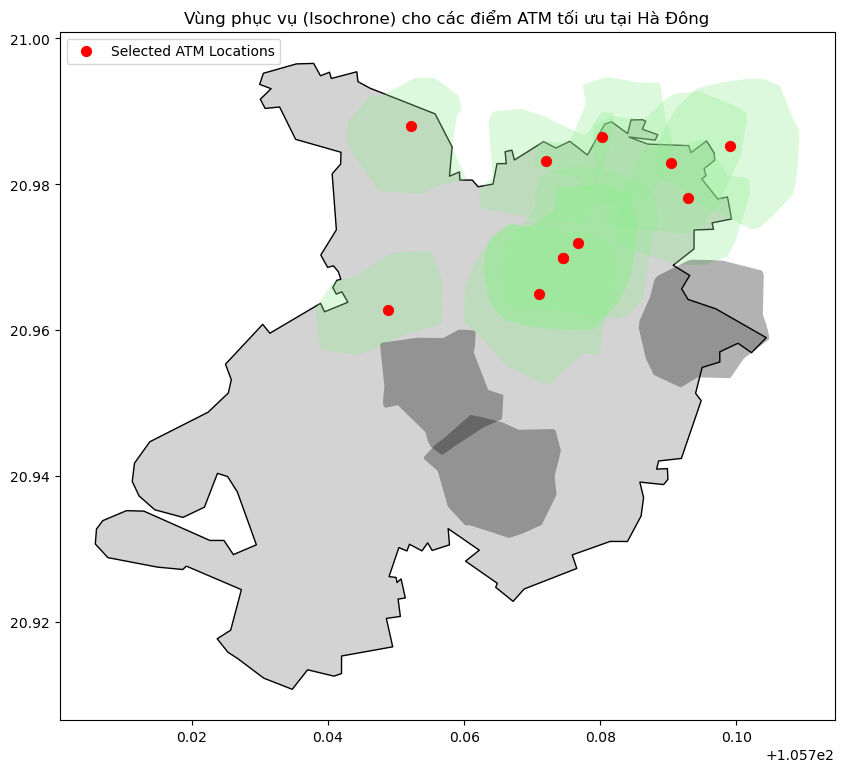

In [36]:
import matplotlib.pyplot as plt

# Lọc các isochrones cho các điểm ATM tối ưu đã chọn từ cả isochrone_gdf và isochrone_existing_atm_gdf
isochrone_selected_atms = isochrone_gdf[isochrone_gdf.index.isin(selected_ATMs)]
isochrone_selected_existing_atms = isochrone_existing_atm_gdf[isochrone_existing_atm_gdf.index.isin(selected_ATMs)]

# Plot bản đồ với các isochrone và điểm ATM đã chọn
fig, ax = plt.subplots(figsize=(10, 10))

# Hiển thị ranh giới khu vực (ví dụ: Hà Đông)
selected_gdf.plot(ax=ax, color="lightgrey", edgecolor="black")  # Bản đồ khu vực

# Hiển thị isochrones của các ATM hiện có đã chọn
isochrone_selected_existing_atms.plot(ax=ax, color="lightgreen", alpha=0.3, label="Existing ATM Isochrone")

# Hiển thị isochrones của các ATM tiềm năng đã chọn
isochrone_selected_atms.plot(ax=ax, color="black", alpha=0.3, label="Potential ATM Isochrone")

# Hiển thị các điểm ATM đã chọn trên bản đồ
filtered_data[filtered_data.index.isin(selected_ATMs)].plot(ax=ax, color="red", markersize=50, label="Selected ATM Locations")

# Tùy chỉnh tiêu đề và chú thích
plt.title("Vùng phục vụ (Isochrone) cho các điểm ATM tối ưu tại Hà Đông")
plt.legend(loc="upper left")

# Hiển thị bản đồ
plt.show()

In [37]:
coverage_percentage = calculate_max_coverage(population_in_hadong, isochrone_existing_atm_gdf)
print(f"Khả năng tiếp cận tối đa của các điểm ATM tiềm năng: {coverage_percentage:.2f}%")

Khả năng tiếp cận tối đa của các điểm ATM tiềm năng: 41.38%


In [38]:
def calculate_combined_coverage(population_gdf, isochrone_existing_gdf, isochrone_new_gdf):
    """
    Tính toán mức độ bao phủ hiện tại của các điểm ATM bao gồm cả điểm hiện có và điểm mới.

    Parameters:
    - population_gdf (GeoDataFrame): Dữ liệu dân số với các điểm dân cư.
    - isochrone_existing_gdf (GeoDataFrame): Isochrones của các điểm ATM hiện có.
    - isochrone_new_gdf (GeoDataFrame): Isochrones của các điểm ATM mới được đề xuất.

    Returns:
    - float: Phần trăm dân số được bao phủ hiện tại.
    """
    # Bước 1: Kết hợp tất cả các isochrones lại thành một vùng phủ tổng hợp
    combined_isochrone_area = unary_union(
        list(isochrone_existing_gdf.geometry) + list(isochrone_new_gdf.geometry)
    )

    # Bước 2: Lọc các điểm dân cư nằm trong vùng phủ tổng hợp
    population_within_combined_coverage = population_gdf[population_gdf.within(combined_isochrone_area)]

    # Bước 3: Tính tổng dân số trong vùng phủ tổng hợp
    covered_population = population_within_combined_coverage['population'].sum()
    total_population = population_gdf['population'].sum()

    # Bước 4: Tính phần trăm dân số được phục vụ
    coverage_percentage = (covered_population / total_population) * 100
    return coverage_percentage

# Sử dụng hàm để tính độ bao phủ hiện tại
current_coverage_percentage = calculate_combined_coverage(population_in_hadong, isochrone_existing_atm_gdf, isochrone_selected_atms)
print(f"Khả năng bao phủ hiện tại của các điểm ATM: {current_coverage_percentage:.2f}%")

Khả năng bao phủ hiện tại của các điểm ATM: 61.93%


In [39]:
def process_value(each_val):
    # Khởi tạo lại mô hình mỗi lần gọi hàm để đảm bảo tính độc lập
    model = model_max_covering(w, I, J, JI, each_val, J_existing)
    solver.solve(model)
    
    # Lấy danh sách các ID của ATM đã được chọn mở (cả mới và cũ)
    opened_ids = [j for j in J if model.x[j].value == 1]
    
    # Lọc các isochrones của ATM mới được chọn mở
    selected_isochrones_new = isochrone_gdf[isochrone_gdf.index.isin(opened_ids)]
    
    # Lọc các isochrones của ATM cũ đã mở
    selected_isochrones_existing = isochrone_existing_atm_gdf[isochrone_existing_atm_gdf.index.isin(J_existing)]
    
    # Kết hợp các isochrones của cả ATM mới và ATM cũ
    combined_area = unary_union(list(selected_isochrones_new.geometry) + list(selected_isochrones_existing.geometry))
    
    # Tìm các khu vực dân cư nằm trong vùng phủ tổng hợp này
    pop_with_access = population_in_hadong[population_in_hadong.within(combined_area)]
    pop_without_access = population_in_hadong[~population_in_hadong.within(combined_area)]
    
    # Tính phần trăm dân số được bao phủ
    total_population = population_in_hadong['population'].sum()
    pop_percentage = round(pop_with_access['population'].sum() * 100 / total_population, 2)
    
    return each_val, len(opened_ids), pop_percentage

# Danh sách các giá trị để xử lý
values_to_process = range(len(grid_points))

# Chạy tuần tự để kiểm tra lỗi
result_list = [process_value(val) for val in tqdm(values_to_process)]

  0%|          | 0/42 [00:00<?, ?it/s]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298014239267000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      142846.030258
  Dual bound        142846.030258
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    142846.030258 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.02 (total)
                    0.02 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                

  2%|▏         | 1/42 [00:01<01:04,  1.58s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298015831222000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  1s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     4.0s
 T       0       0         0   0.00%   336206.608618  

  5%|▍         | 2/42 [00:07<02:53,  4.34s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298022106399000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

  7%|▋         | 3/42 [00:10<02:20,  3.62s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298024847584000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 10%|▉         | 4/42 [00:13<02:01,  3.19s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298027388225000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 12%|█▏        | 5/42 [00:15<01:51,  3.01s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298030073622000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 T       0       0         0   0.00%   336206.608618  

 14%|█▍        | 6/42 [00:18<01:46,  2.95s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298032940620000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 T       0       0         0   0.00%   336206.608618  

 17%|█▋        | 7/42 [00:21<01:43,  2.95s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298035895117000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 19%|█▉        | 8/42 [00:24<01:38,  2.89s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298038640935000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 R       0       0         0   0.00%   271044.605896  

 21%|██▏       | 9/42 [00:28<01:44,  3.17s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298042432139000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 R       0       0         0   0.00%   278247.260978  

 24%|██▍       | 10/42 [00:35<02:18,  4.33s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298049350252000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   285269.311103  

 26%|██▌       | 11/42 [00:42<02:42,  5.23s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298056617446000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   291375.478663  

 29%|██▊       | 12/42 [00:50<03:04,  6.15s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298064872351000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   297193.324483  

 31%|███       | 13/42 [01:09<04:48,  9.96s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298083587067000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   302706.075759  

 33%|███▎      | 14/42 [01:33<06:38, 14.24s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298107712939000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   308090.149581  

 36%|███▌      | 15/42 [01:39<05:20, 11.86s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298114048033000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 R       0       0         0   0.00%   313328.855914  

 38%|███▊      | 16/42 [01:58<06:04, 14.04s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298133153664000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   317772.604564  

 40%|████      | 17/42 [02:04<04:45, 11.42s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298138480618000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   320645.083388  

 43%|████▎     | 18/42 [02:21<05:13, 13.07s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298155407472000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   323124.824003  

 45%|████▌     | 19/42 [02:25<04:00, 10.45s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298159756156000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 R       0       0         0   0.00%   325246.456157  

 48%|████▊     | 20/42 [02:29<03:04,  8.40s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298163369331000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 50%|█████     | 21/42 [02:32<02:22,  6.79s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298166421937000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 T       0       0         0   0.00%   336206.608618  

 52%|█████▏    | 22/42 [02:35<01:54,  5.72s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298169647186000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 T       0       0         0   0.00%   336206.608618  

 55%|█████▍    | 23/42 [02:38<01:35,  5.03s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298173071044000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.5s
 T       0       0         0   0.00%   336206.608618  

 57%|█████▋    | 24/42 [02:42<01:22,  4.56s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298176528150000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 60%|█████▉    | 25/42 [02:45<01:11,  4.19s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298179853066000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 62%|██████▏   | 26/42 [02:48<01:02,  3.94s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298183200581000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 64%|██████▍   | 27/42 [02:52<00:56,  3.76s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298186542774000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 67%|██████▋   | 28/42 [02:55<00:50,  3.62s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298189854425000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 69%|██████▉   | 29/42 [02:58<00:46,  3.54s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298193199104000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 71%|███████▏  | 30/42 [03:02<00:42,  3.50s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298196609513000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 74%|███████▍  | 31/42 [03:05<00:38,  3.47s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298200014212000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 76%|███████▌  | 32/42 [03:09<00:34,  3.49s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298203550903000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 79%|███████▊  | 33/42 [03:13<00:31,  3.56s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298215485562000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s
 T       0       0         0   0.00%   336206.608618  

 81%|████████  | 34/42 [03:33<01:09,  8.68s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298227914930000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s

Solving report
  Status            Optimal
  Primal b

 83%|████████▎ | 35/42 [03:37<00:50,  7.22s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298231723894000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 5e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s

Solving report
  Status            Optimal
  Primal b

 86%|████████▌ | 36/42 [03:41<00:37,  6.18s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298235454735000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 5e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s

Solving report
  Status            Optimal
  Primal b

 88%|████████▊ | 37/42 [03:44<00:27,  5.45s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298239193866000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 5e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
13934 rows, 13971 cols, 41113 nonzeros  0s

Solving MIP model with:
   13934 rows
   13971 cols (13971 binary, 0 integer, 0 implied int., 0 continuous)
   41113 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   336206.608618   -inf                 inf        0      0      0         0     0.4s

Solving report
  Status            Optimal
  Primal b

 90%|█████████ | 38/42 [03:48<00:19,  4.92s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298242896607000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 5e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      336206.608618
  Dual bound        336206.608618
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    336206.608618 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.08 (total)
                    0.08 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                

 93%|█████████▎| 39/42 [03:51<00:13,  4.36s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298245952242000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 5e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      336206.608618
  Dual bound        336206.608618
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    336206.608618 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.02 (total)
                    0.02 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                

 95%|█████████▌| 40/42 [03:54<00:07,  3.97s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298249011584000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 5e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      336206.608618
  Dual bound        336206.608618
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    336206.608618 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.02 (total)
                    0.02 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                

 98%|█████████▊| 41/42 [03:57<00:03,  3.69s/it]

Running HiGHS 1.7.2 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Number of BV entries in BOUNDS section is 23606
MIP  model1733298252037164000 has 23565 rows; 23606 cols; 91940 nonzeros; 23606 integer variables
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e+00, 3e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 5e+01]
Presolving model
22641 rows, 22682 cols, 69457 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve: Optimal

Solving report
  Status            Optimal
  Primal bound      336206.608618
  Dual bound        336206.608618
  Gap               0% (tolerance: 0.01%)
  Solution status   feasible
                    336206.608618 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            0.02 (total)
                    0.02 (presolve)
                    0.00 (postsolve)
  Nodes             0
  LP iterations     0 (total)
                    0 (strong br.)
                

100%|██████████| 42/42 [04:00<00:00,  5.74s/it]


In [40]:
print(result_list)

[(0, 11, 41.38), (1, 12, 50.3), (2, 13, 56.2), (3, 14, 61.93), (4, 15, 66.6), (5, 16, 71.14), (6, 17, 74.11), (7, 18, 76.37), (8, 19, 78.5), (9, 20, 80.55), (10, 21, 82.57), (11, 22, 84.34), (12, 23, 86.02), (13, 24, 87.62), (14, 25, 89.18), (15, 26, 90.55), (16, 27, 91.98), (17, 28, 92.81), (18, 29, 93.58), (19, 30, 94.21), (20, 31, 94.81), (21, 32, 95.35), (22, 33, 95.85), (23, 34, 96.16), (24, 35, 96.44), (25, 36, 96.69), (26, 37, 96.93), (27, 38, 97.08), (28, 39, 97.23), (29, 40, 97.28), (30, 41, 97.33), (31, 42, 97.37), (32, 43, 97.38), (33, 44, 97.39), (34, 45, 97.4), (35, 45, 97.4), (36, 45, 97.4), (37, 45, 97.4), (38, 49, 97.4), (39, 50, 97.4), (40, 50, 97.4), (41, 50, 97.4)]


In [41]:
import plotly.graph_objects as go

# Tách dữ liệu từ `result_list`
x_values = [item[0] for item in result_list]  # Ngân sách (số ATM mở)
y_values = [item[2] for item in result_list]  # Phần trăm dân số được bao phủ

# Tạo đồ thị
fig = go.Figure()

# Đường cong Pareto
fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines+markers', name='Pareto Frontier'))

# Cài đặt bố cục
fig.update_layout(
    title="Đường cong Pareto: Mối quan hệ giữa số lượng cơ sở (ATM) mở mới và độ bao phủ dân số",
    xaxis_title="Số lượng cơ sở (ATM) mở mới",
    yaxis_title="Phần trăm dân số được bao phủ",
)

# Thêm các đường kẻ ngang và dọc để hiển thị ngưỡng tối ưu (nếu cần)
optimal_y = max(y_values)
optimal_x = x_values[y_values.index(optimal_y)]

fig.add_shape(type="line",
              x0=optimal_x, y0=0, x1=optimal_x, y1=optimal_y,
              line=dict(dash="dash", color="green"))
fig.add_shape(type="line",
              x0=0, y0=optimal_y, x1=optimal_x, y1=optimal_y,
              line=dict(dash="dash", color="green"))

# Thêm chú thích vào điểm tối ưu
fig.add_annotation(x=optimal_x, y=optimal_y,
                   text=f"Số lượng dân số tối đa có thể bao phủ {optimal_y}%",
                   showarrow=True, arrowhead=1)

# Hiển thị đồ thị
fig.show()